In [1]:
"""
1.项目背景
2.数据简介
3.导入必备的工具包
4.数据读取
5.数据标签分布--'0'类+‘1’类
6.数据标准化处理--sklearn处理Amount和Time数据，得到数据集样本分布情况
7.下采样方案:数据集样本分布情况，提出下采样方案。解决原始数据集样本不均衡，得到一个下采样数据集
8.数据集切分--'原始数据集’和‘下采样数据集’各自都切分成训练集+验证集+测试集
9.交叉验证:用逻辑回归模型，采用交叉验证方法来评估（本方案使用KFlod）——在下采样的训练集+验证集中找到最好的模型参数
（之所以能够选择使用逻辑回归作为第一个算法，可能是因为这个算法的简单及普遍适用性。）
10,11.观察上述‘最好的模型’，分别在‘下采样的测试集’和‘原始数据的测试集’中的表现——使用混淆矩阵的方法
12.用原始数据计算最好模型的方案: 直接使用原始数据来计算模型
13.阈值对结果的影响
14.过采样方案:基于SMOTE算法对异常样本集（正例）进行样本生成，解决原始数据集样本不均衡的问题，得到一个过采样数据集
15.项目总结
"""

"\n1.项目背景\n2.数据简介\n3.导入必备的工具包\n4.数据读取\n5.数据标签分布--'0'类+‘1’类\n6.数据标准化处理--sklearn处理Amount和Time数据，得到数据集样本分布情况\n7.下采样方案:数据集样本分布情况，提出下采样方案。解决原始数据集样本不均衡，得到一个下采样数据集\n8.数据集切分--'原始数据集’和‘下采样数据集’各自都切分成训练集+验证集+测试集\n9.交叉验证:用逻辑回归模型，采用交叉验证方法来评估（本方案使用KFlod）——在下采样的训练集+验证集中找到最好的模型参数\n（之所以能够选择使用逻辑回归作为第一个算法，可能是因为这个算法的简单及普遍适用性。）\n10,11.观察上述‘最好的模型’，分别在‘下采样的测试集’和‘原始数据的测试集’中的表现——使用混淆矩阵的方法\n12.用原始数据计算最好模型的方案: 直接使用原始数据来计算模型\n13.阈值对结果的影响\n14.过采样方案:基于SMOTE算法对异常样本集（正例）进行样本生成，解决原始数据集样本不均衡的问题，得到一个过采样数据集\n15.项目总结\n"

In [2]:
#3.导入必备的工具包
import numpy as np
import os
data_path = '../data/' #向上翻两级
import time
ts = time.time()

import matplotlib.pyplot as plt
#如果你使用Jupyter，在绘图之前，不要忘记写这一行(在代码中只写一次),目的是将图表嵌入到Notebook中
%matplotlib inline

#忽略警告信息，有时会因为版本的问题出现编译警告信息，但不影响运行结果
import warnings
warnings.filterwarnings('ignore')
    
import pandas as pd
pd.set_option('display.max_rows', 50)        # 在控制台显示dataframe数据最多行数(头尾各25行),超过后自动省略
pd.set_option('display.max_columns', 50)     # 在控制台显示dataframe数据最多列数,超过后自动省略
    
from tqdm import tqdm
import seaborn as sns
from numpy import NaN


In [3]:
#4.数据读取
# 载入Excel记录文件
data = pd.read_csv(os.path.join(data_path, 'creditcard.csv'))  #读数据库，data是DataFrame格式1
data.head(7)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0


In [4]:
print(data.shape)

(284807, 31)


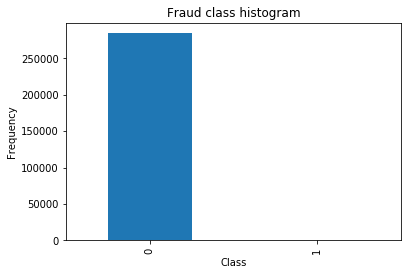

In [5]:
#5.数据标签分布--‘0’类+‘1’类
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()  # value_counts() 数数
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar')


In [6]:
print(count_classes)

0    284315
1       492
Name: Class, dtype: int64


In [7]:
#6.数据标准化处理--sklearn处理Amount和Time数据，得到数据集样本分布情况
# 把Amount列做标准化。
from sklearn.preprocessing import StandardScaler
# LiM：加入.values是为了把Series类型转化为ndarray结构，标准化圈定在(-1,1)域
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1)) 
data = data.drop(['Time', 'Amount'], axis=1)
data.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [8]:
#7.下采样方案:数据集样本分布情况，提出下采样方案。解决原始数据集样本不均衡，得到一个下采样数据集
# 将数据集分类,分为样本集X，和标签集y。这个也叫“切片”。
# data.columns != 是指，将数据集中列名称不是‘Class’的选取出来送到X
X = data.iloc[:, data.columns != 'Class']
# data.columns == 是指，将数据集中列名称是‘Class’的选取出来送到y
y = data.iloc[:, data.columns == 'Class']


In [9]:
#“异常样本个数”存放在number_records_fraud
number_records_fraud = len(data[data.Class == 1])
#.index是取data[]的索引地址，np.array将输入转为矩阵格式，再送到“异常样本索引集fraud_indices”存放
fraud_indices = np.array(data[data.Class == 1].index)

#得到正常样本的索引，由于正常样本很多，涉及到随机抽取
normal_indices = data[data.Class == 0].index

#在正常样本中，随机采样出指定个数的样本（492个），并得到索引。否则正常样本数量太大太大，导致针对异常样本的不均衡imbalance.
# 现在各占一半。
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False) #false指只挑选不替换 
#np.array()是指，将输入转换成矩阵形式，然后再送到“随机正常样本索引集”存放
random_normal_indices = np.array(random_normal_indices)

#有了正常样本和异常样本后，把它们的索引都拿到手
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

#根据索引得到下采样所有样本点
under_sample_data = data.iloc[under_sample_indices,:]

#将下采样数据集分成X、y两类
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

#下采样数据集的样本比例
print("正常样本所占整体比例: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("异常样本所占整体比例: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("下采样策略总体样本数量: ", len(under_sample_data))


正常样本所占整体比例:  0.5
异常样本所占整体比例:  0.5
下采样策略总体样本数量:  984


In [10]:
#8.数据集切分--原始数据集’和‘下采样数据集’各自都切分成训练集+验证集+测试集
from sklearn.model_selection import train_test_split

# 对原始数据集进行切分
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
print("原始训练集包含样本数量: ", len(X_train))
print("原始测试集包含样本数量: ", len(X_test))
print("原始样本总数: ", len(X_train)+len(X_test))

原始训练集包含样本数量:  199364
原始测试集包含样本数量:  85443
原始样本总数:  284807


In [11]:
# 对下采样数据集进行切分
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)

print("")
print("下采样训练集包含样本数量: ", len(X_train_undersample))
print("下采样测试集包含样本数量: ", len(X_test_undersample))
print("下采样样本总数: ", len(X_train_undersample)+len(X_test_undersample))


下采样训练集包含样本数量:  688
下采样测试集包含样本数量:  296
下采样样本总数:  984


In [12]:
#9.交叉验证:用逻辑回归模型，采用交叉验证方法来评估（本方案使用KFlod）——在下采样的训练集+验证集中找到最好的模型参数
#在sklearn库的线性模块中，调取“逻辑回归”
from sklearn.linear_model import LogisticRegression  

#武器库如下：
#交叉验证模块中，选用“K折交叉验证”。
#cross_val_score函数返回的是一个使用交叉验证以后的评分标准。可以通过交叉验证评估分数，非常方便。
from sklearn.model_selection import KFold, cross_val_score  

#混淆矩阵、召回率
#sklearn中的classification_report函数用于显示主要分类指标的文本报告，在报告中显示每个类的精确度，召回率，F1值等信息。
from sklearn.metrics import confusion_matrix,recall_score,classification_report 
#cross_val_predict 和 cross_val_score的使用方法是一样的，但是它返回的是一个使用交叉验证以后的输出值，而不是评分标准。
from sklearn.model_selection import cross_val_predict


In [13]:
#编写Kflod函数——printing_Kfold_scores，实际中我们可以直接调用
def printing_Kfold_scores(x_train_data,y_train_data):
    #fold = KFold(len(y_train_data),5,shuffle=False)      #shuffle=False是指数据集不用洗牌. LiM:原文有问题,
    #而且放在这里会导致下面第一个for循环执行以后，再执行第二遍是就不进入嵌套的字for循环了，所以位置需要下移。


    # 定义不同力度的正则化惩罚力度
    c_param_range = [0.01,0.1,1,10,100]   
    
    # 展示结果用的表格
    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range
    
    # k-fold 表示K折的交叉验证，这里会得到两个索引集合: 训练集 = indices[0], 验证集 = indices[1]
    j = 0
    # 循环遍历不同的参数（这里的c_param_rang是5个——5折交叉验证）
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('正则化惩罚力度: ', c_param)
        print('-------------------------------------------')
        print('')
        
        #计算每一次迭代后的召回率，一次5次
        recall_accs = []
        #LiM：从上面移动到这个位置
        fold = KFold(5,shuffle=False).split(y_train_data)
        #一步步分解来执行交叉验证:
        for iteration, indices in enumerate(fold,start=1):
            # 选择算法模型+给定参数
            lr = LogisticRegression(C = c_param, penalty = 'l2')  #L1正则化防止过拟合，通过k折交叉验证寻找最佳的参数C。 
            # 训练模型。注意索引不要给错了，训练的时候一定传入的是训练集，所以X和Y的索引都是0
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())
            # 测试模型。这里用验证集预测模型结果，这里用的就是验证集，索引为1，验证集 = indices[1]
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
            # 评估模型。有了预测结果之后就可以来进行评估了，这里recall_score需要传入预测值和真实值。
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            # 一会还要算平均，所以把每一步的结果都先保存起来。
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': 召回率 = ', recall_acc)
        
        #当执行完所有的交叉验证后，计算平均结果
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1                           #在这儿的意思是 num = num + 1，如果不输入这一行代码,那么 num 永远都会等于 1
        print('')
        print('平均召回率 ', np.mean(recall_accs))
        print('')
 
    # 找到最好的参数，哪一个Recall高，自然就是最好的了。
    best_c = results_table.loc[results_table['Mean recall score'].astype('float32').idxmax()]['C_parameter']
 
    # 打印最好的结果
    print('*********************************************************************************')
    print('效果最好的模型所选参数 = ', best_c)
    print('*********************************************************************************')
 
    return best_c


In [14]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
正则化惩罚力度:  0.01
-------------------------------------------

Iteration  1 : 召回率 =  0.8356164383561644
Iteration  2 : 召回率 =  0.8493150684931506
Iteration  3 : 召回率 =  0.9322033898305084
Iteration  4 : 召回率 =  0.9324324324324325
Iteration  5 : 召回率 =  0.8787878787878788

平均召回率  0.8856710415800271

-------------------------------------------
正则化惩罚力度:  0.1
-------------------------------------------

Iteration  1 : 召回率 =  0.8493150684931506
Iteration  2 : 召回率 =  0.9041095890410958
Iteration  3 : 召回率 =  0.9661016949152542
Iteration  4 : 召回率 =  0.9459459459459459
Iteration  5 : 召回率 =  0.8939393939393939

平均召回率  0.9118823384669682

-------------------------------------------
正则化惩罚力度:  1
-------------------------------------------

Iteration  1 : 召回率 =  0.8767123287671232
Iteration  2 : 召回率 =  0.9041095890410958
Iteration  3 : 召回率 =  0.9661016949152542
Iteration  4 : 召回率 =  0.9459459459459459
Iteration  5 : 召回率 =  0.8939393939393939

平均召回率  0.91736179052

In [15]:
#10.观察上述‘最好的模型’，分别在‘下采样的测试集’和‘原始数据的测试集’中的表现——使用混淆矩阵的方法
# 先定义混淆矩阵
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=0)
    #plt.yticks(tick_marks, classes, rotation=0)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "green")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

召回率:  0.9251700680272109


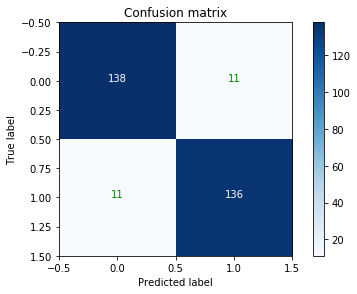

In [16]:
#10.1通过混淆矩阵，观察‘最好的模型’在‘下采样的测试集’中的表现
import itertools

# 输入参数
lr = LogisticRegression(C = best_c, penalty = 'l2')  # 因为报错，原本是l1, 不得以改到l2.
# 训练模型
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
# 测试模型
y_pred_undersample = lr.predict(X_test_undersample.values)
# 计算所需值.confusion_matrix()是sklearn里面的函数。
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
#确定浮点数字、数组、和numpy对象的显示形式
np.set_printoptions(precision=2)
print("召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 绘制
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix')
plt.show()

召回率:  0.9251700680272109


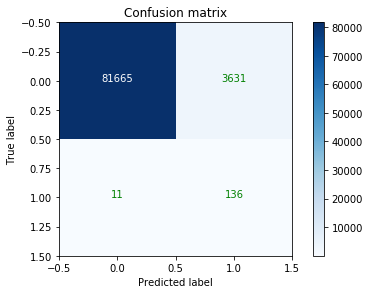

In [17]:
#10.2(11)通过混淆矩阵，观察‘最好的模型’在‘原始数据的测试集’中的表现

# 输入参数
lr = LogisticRegression(C = best_c, penalty = 'l2')
# 训练模型
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
# 测试模型
y_pred = lr.predict(X_test.values)
# 计算所需值
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
print("召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 绘制
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
, classes=class_names
, title='Confusion matrix')
plt.show()


In [18]:
best_c = printing_Kfold_scores(X_train,y_train)

-------------------------------------------
正则化惩罚力度:  0.01
-------------------------------------------

Iteration  1 : 召回率 =  0.5373134328358209
Iteration  2 : 召回率 =  0.6164383561643836
Iteration  3 : 召回率 =  0.6666666666666666
Iteration  4 : 召回率 =  0.6
Iteration  5 : 召回率 =  0.5

平均召回率  0.5840836911333742

-------------------------------------------
正则化惩罚力度:  0.1
-------------------------------------------

Iteration  1 : 召回率 =  0.5522388059701493
Iteration  2 : 召回率 =  0.6164383561643836
Iteration  3 : 召回率 =  0.7166666666666667
Iteration  4 : 召回率 =  0.6153846153846154
Iteration  5 : 召回率 =  0.5625

平均召回率  0.612645688837163

-------------------------------------------
正则化惩罚力度:  1
-------------------------------------------

Iteration  1 : 召回率 =  0.5522388059701493
Iteration  2 : 召回率 =  0.6164383561643836
Iteration  3 : 召回率 =  0.7333333333333333
Iteration  4 : 召回率 =  0.6153846153846154
Iteration  5 : 召回率 =  0.575

平均召回率  0.6184790221704963

-------------------------------------------
正则化惩罚

Recall metric in the testing dataset:  0.6190476190476191


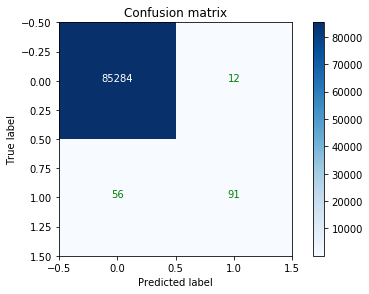

In [19]:
#12.用原始数据计算最好模型的方案: 直接使用原始数据来计算模型
#‘最好的模型’，在‘原始数据的测试集’中的表现——混淆矩阵
# 建模。选择算法+给定参数
lr = LogisticRegression(C = best_c, penalty = 'l2')
# 训练模型
lr.fit(X_train,y_train.values.ravel())
# 测试模型
y_pred_undersample = lr.predict(X_test.values)

# 评估模型。计算混淆矩阵
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

给定阈值为: 0.1 时测试集召回率:  0.9931972789115646
给定阈值为: 0.2 时测试集召回率:  0.9523809523809523
给定阈值为: 0.3 时测试集召回率:  0.9319727891156463
给定阈值为: 0.4 时测试集召回率:  0.9047619047619048
给定阈值为: 0.5 时测试集召回率:  0.8707482993197279
给定阈值为: 0.6 时测试集召回率:  0.8503401360544217
给定阈值为: 0.7 时测试集召回率:  0.8503401360544217
给定阈值为: 0.8 时测试集召回率:  0.8163265306122449
给定阈值为: 0.9 时测试集召回率:  0.7755102040816326


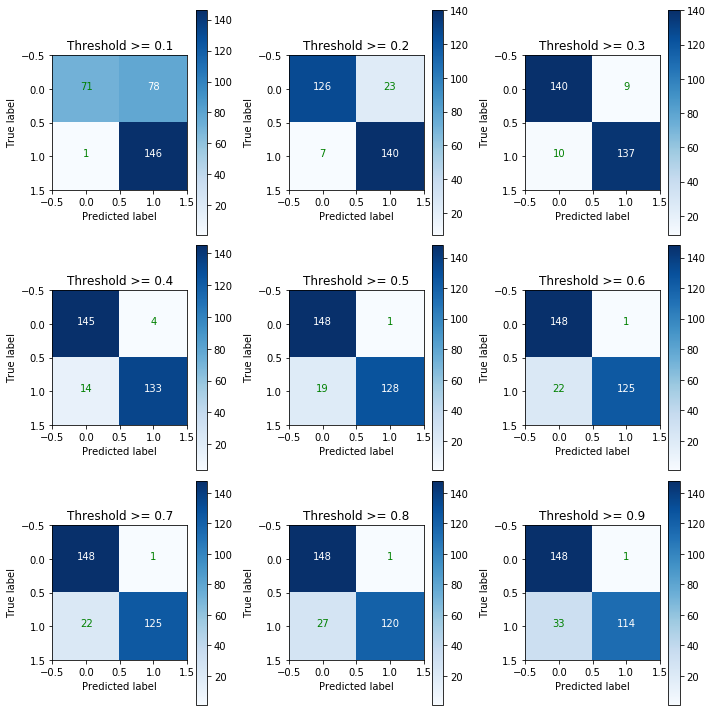

In [20]:
#阈值对结果的影响。逻辑回归中的激活函数，默认阈值为0.5
# 【1】
# 建模。选择算法+给定参数
lr = LogisticRegression(C = 0.01, penalty = 'l2')
# 训练模型。还是用下采样的训练集
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
# 预测概率。得到预测结果的概率值
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)
# 指定不同的阈值。为了展示，这里用了9个值
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


#【2】
# 指定图的大小
plt.figure(figsize=(10,10))

j = 1
# 用混淆矩阵来进行展示
for i in thresholds:
    #阈值判断
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i    
    #画出3*3的图，j是第几个图
    plt.subplot(3,3,j)  
    j += 1
    
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    #精度为小数点后2位
    np.set_printoptions(precision=2)    
    #打印不同阈值时候的召回率
    print("给定阈值为:",i,"时测试集召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    #定义种类的标签“0”、“1”
    class_names = [0,1]    
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

In [21]:
#建立过采样集。。。。。。
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [22]:
# 读取数据集
credit_cards = pd.read_csv(os.path.join(data_path, 'creditcard.csv'))
# 取数据集中的列
columns=credit_cards.columns
# 在特征中去除掉标签
features_columns=columns.delete(len(columns)-1)
#分成特征和标签两个
features=credit_cards[features_columns]
labels=credit_cards['Class']

#数据集的切分
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.3, 
                                                                            random_state=0)

In [23]:
#基于SMOTE算法来进行样本生成，这样正例（异常）和负例（正常）样本数量就是一致的了
oversampler=SMOTE(random_state=0)

os_features,os_labels=oversampler.fit_sample(features_train,labels_train)

#计算样本数量
len(os_labels[os_labels==1])

#数据转换
os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)

# 交叉验证，找到最好的参数
best_c = printing_Kfold_scores(os_features,os_labels)


-------------------------------------------
正则化惩罚力度:  0.01
-------------------------------------------

Iteration  1 : 召回率 =  0.8785714285714286
Iteration  2 : 召回率 =  0.888
Iteration  3 : 召回率 =  0.9663125948406677
Iteration  4 : 召回率 =  0.9578805883904682
Iteration  5 : 召回率 =  0.9579685203562501

平均召回率  0.9297466264317629

-------------------------------------------
正则化惩罚力度:  0.1
-------------------------------------------

Iteration  1 : 召回率 =  0.9071428571428571
Iteration  2 : 召回率 =  0.888
Iteration  3 : 召回率 =  0.9494688922610015
Iteration  4 : 召回率 =  0.959149321039607
Iteration  5 : 召回率 =  0.9602170663383873

平均召回率  0.9327956273563707

-------------------------------------------
正则化惩罚力度:  1
-------------------------------------------

Iteration  1 : 召回率 =  0.9071428571428571
Iteration  2 : 召回率 =  0.888
Iteration  3 : 召回率 =  0.9494688922610015
Iteration  4 : 召回率 =  0.9592246912959915
Iteration  5 : 召回率 =  0.9589483336892485

平均召回率  0.9325569548778198

---------------------------------

召回率:  0.8707482993197279


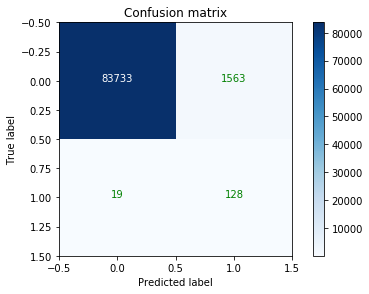

In [24]:
# 建模。选算法+给参数
lr = LogisticRegression(C = best_c, penalty = 'l2')
# 训练模型
lr.fit(os_features,os_labels.values.ravel())
# 测试模型
y_pred = lr.predict(features_test.values)

# 计算混淆矩阵
cnf_matrix = confusion_matrix(labels_test,y_pred)
np.set_printoptions(precision=2)

print("召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 绘制
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [ ]:
# 2019-12-08 测试通过